In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

income = pd.read_csv("C:/Users/47089/OneDrive/Desktop/marlabs/income.csv")
income.head()

,age,JobType,EdType,maritalstatus,occupation,relationship,race,gender,capitalgain,capitalloss,hoursperweek,nativecountry,SalStat
0,45,Private,HS-grad,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,28,United-States,"less than or equal to 50,000"
1,24,Federal-gov,HS-grad,Never-married,Armed-Forces,Own-child,White,Male,0,0,40,United-States,"less than or equal to 50,000"
2,44,Private,Some-college,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,"greater than 50,000"
3,27,Private,9th,Never-married,Craft-repair,Other-relative,White,Male,0,0,40,Mexico,"less than or equal to 50,000"
4,20,Private,Some-college,Never-married,Sales,Not-in-family,White,Male,0,0,35,United-States,"less than or equal to 50,000"


In [11]:
def income_model_prep(data):
    from sklearn.model_selection import train_test_split
    data = pd.get_dummies(
        data.assign(
            target = np.where(data["SalStat"] == " less than or equal to 50,000", 0, 1),
            nativecountry = data["nativecountry"].replace({" Holand-Netherlands": " Germany"}),
            occupation = data["occupation"].replace({" Armed-Forces": " ?"}),
            JobType = data["JobType"].replace({" Never-worked": " Without-pay"}),
        ).drop("SalStat", axis=1), 
        drop_first=True
    )
    X = data.drop("target", axis=1)
    y = data["target"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    return X_train, X_test, y_train, y_test

In [37]:
X_train, X_test, y_train, y_test = income_model_prep(income) 

In [38]:
X_train.shape

(25582, 94)

In [39]:
X_train.columns

Index(['age', 'capitalgain', 'capitalloss', 'hoursperweek',
       'JobType_ Federal-gov', 'JobType_ Local-gov', 'JobType_ Private',
       'JobType_ Self-emp-inc', 'JobType_ Self-emp-not-inc',
       'JobType_ State-gov', 'JobType_ Without-pay', 'EdType_ 11th',
       'EdType_ 12th', 'EdType_ 1st-4th', 'EdType_ 5th-6th', 'EdType_ 7th-8th',
       'EdType_ 9th', 'EdType_ Assoc-acdm', 'EdType_ Assoc-voc',
       'EdType_ Bachelors', 'EdType_ Doctorate', 'EdType_ HS-grad',
       'EdType_ Masters', 'EdType_ Preschool', 'EdType_ Prof-school',
       'EdType_ Some-college', 'maritalstatus_ Married-AF-spouse',
       'maritalstatus_ Married-civ-spouse',
       'maritalstatus_ Married-spouse-absent', 'maritalstatus_ Never-married',
       'maritalstatus_ Separated', 'maritalstatus_ Widowed',
       'occupation_ Adm-clerical', 'occupation_ Craft-repair',
       'occupation_ Exec-managerial', 'occupation_ Farming-fishing',
       'occupation_ Handlers-cleaners', 'occupation_ Machine-op-inspct'

# Assignment 1: Simple Tree

1. Build a decision tree with max_depth 3 using the `age`, `hoursperweek` and `gender` features.
2. Calculate accuracy and build a confusion matrix for the test data
3. Plot the tree - which group has the highest probability of making over 50,000?
4. Plot Feature importance - which variable was most important? Are there any we can drop?

In [79]:
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, recall_score, f1_score
from sklearn.tree import plot_tree

In [71]:
X_train_feature = X_train[['age', 'hoursperweek', 'gender_ Male']]
X_test_feature = X_test[['age', 'hoursperweek', 'gender_ Male']]

In [72]:
# Model
clf = DecisionTreeClassifier(max_depth = 3)
clf.fit(X_train_feature, y_train)
# Accuracy
print('The accuracy is: ', clf.score(X_test_feature, y_test))

The accuracy is:  0.7650093808630394


In [73]:
# Confusion matrix
confusion_matrix(y_test, clf.predict(X_test_feature))

array([[4269,  612],
       [ 891,  624]], dtype=int64)

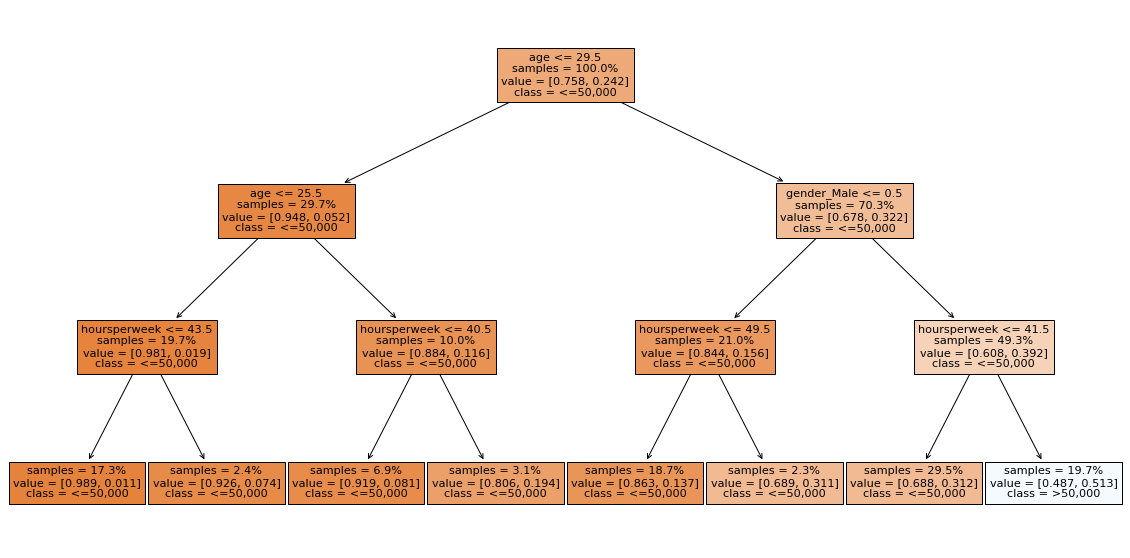

In [74]:
plt.figure(figsize = (20,10))
tree_plot = plot_tree(clf, 
                      feature_names = ['age', 'hoursperweek', 'gender_Male'], 
                      class_names = ['<=50,000', '>50,000'],
                      impurity = False,
                      proportion = True,
                      filled = True,)
plt.show()

Based on the plot, males over the age of 29.5 who work more than 41.5 hours are the most likely to earn over $50,000 (age > 29.5, gender_Male > 0.5, hourseperweek > 41.5). 

<BarContainer object of 3 artists>

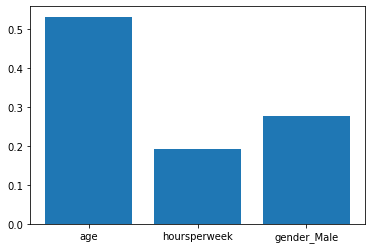

In [78]:
# Feature Importance 
feature_name = ['age', 'hoursperweek', 'gender_Male']
importance = clf.feature_importances_
plt.bar(feature_name, importance)

Age is the most important feature.

# Assignment 2: Hyperparameter Tuning

1. Use cross validation to find the optimal tree parameters. Your process should evaluate different values of max_depth, 'min_samples_leaf', and 'criterion'. 
2. Generate a confusion matrix and report test accuracy, precision, and recall

In [80]:
from sklearn.model_selection import GridSearchCV

# model
clf2 = DecisionTreeClassifier()
param_grid = {
    'max_depth': [3, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'criterion': ['gini', 'entropy'] 
}

grid_search = GridSearchCV(clf2, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_feature, y_train)
print("Best parameters found: ", grid_search.best_params_)

best_clf = grid_search.best_estimator_
print(best_clf)
print('Test accuracy is: ', best_clf.score(X_test_feature, y_test))

Best parameters found:  {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 3}
DecisionTreeClassifier(max_depth=5, min_samples_leaf=3)
Test accuracy is:  0.7786116322701688


In [81]:
# Confusion matrix, precision, and recall
print('Confusion Matrix:\n', confusion_matrix(y_test, best_clf.predict(X_test_feature)))
print('Precision: ', precision_score(y_test, best_clf.predict(X_test_feature)))
print('Recall: ', recall_score(y_test, best_clf.predict(X_test_feature)))

Confusion Matrix:
 [[4461  420]
 [ 996  519]]
Precision:  0.5527156549520766
Recall:  0.3425742574257426
